In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import math
from scipy import stats
import os 
import numpy as np
import h5py
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [8]:
directory_path = os.path.join('../data/')

anormal_files = os.listdir(os.path.join(directory_path, "donnees_anorm"))
ANORMAL_FILES = [directory_path+"donnees_anorm/"+name for name in anormal_files if ".h5" in name]

normal_files =  os.listdir(os.path.join(directory_path, "donnees_norm"))
NORMAL_FILES = [directory_path+"donnees_norm/"+name for name in normal_files if ".h5" in name]

ALL_FILES = NORMAL_FILES + ANORMAL_FILES 
print(ALL_FILES)

['../data/donnees_norm/Scenario_id_001275.h5', '../data/donnees_norm/Scenario_id_001276.h5', '../data/donnees_norm/Scenario_id_001278.h5', '../data/donnees_norm/Scenario_id_001279.h5', '../data/donnees_norm/Scenario_id_001280.h5', '../data/donnees_norm/Scenario_id_001281.h5', '../data/donnees_norm/Scenario_id_001282.h5', '../data/donnees_norm/Scenario_id_001283.h5', '../data/donnees_norm/Scenario_id_001284.h5', '../data/donnees_norm/Scenario_id_001285.h5', '../data/donnees_norm/Scenario_id_001287.h5', '../data/donnees_norm/Scenario_id_001288.h5', '../data/donnees_norm/Scenario_id_001289.h5', '../data/donnees_norm/Scenario_id_001290.h5', '../data/donnees_norm/Scenario_id_001292.h5', '../data/donnees_norm/Scenario_id_001293.h5', '../data/donnees_norm/Scenario_id_001294.h5', '../data/donnees_norm/Scenario_id_001295.h5', '../data/donnees_norm/Scenario_id_001296.h5', '../data/donnees_norm/Scenario_id_001297.h5', '../data/donnees_norm/Scenario_id_001298.h5', '../data/donnees_norm/Scenario_id

## TODO:

- redraw coavriance matrix
- look at daw manually and remove unusful features (locatisation)
- Normalization
- etc... 

## View a data sample

In [9]:
# Load the data
data = pd.read_hdf('../data/donnees_norm/Scenario_id_001275.h5')
data.head()

,sim/time/total_running_time_sec,sim/time/total_flight_time_sec,sim/aircraft/overflow/acf_nosewheel_k,sim/cockpit/electrical/generator_apu_on,sim/cockpit/electrical/gpu_on,sim/cockpit/electrical/generator_apu_amps,sim/cockpit/gyros/the_vac_ind_deg,sim/cockpit/gyros/the_ele_ind_deg,sim/cockpit/gyros/the_ind_deg3,sim/cockpit/gyros/the_ind_deg4,...,sim/cockpit2/tcas/targets/position/weight_on_wheels54,sim/cockpit2/tcas/targets/position/weight_on_wheels55,sim/cockpit2/tcas/targets/position/weight_on_wheels56,sim/cockpit2/tcas/targets/position/weight_on_wheels57,sim/cockpit2/tcas/targets/position/weight_on_wheels58,sim/cockpit2/tcas/targets/position/weight_on_wheels59,sim/cockpit2/tcas/targets/position/weight_on_wheels60,sim/cockpit2/tcas/targets/position/weight_on_wheels61,sim/cockpit2/tcas/targets/position/weight_on_wheels62,sim/cockpit2/tcas/targets/position/weight_on_wheels63
0,5504.165527,0.251256,0.0,0,0,0.0,0.473039,0.473039,0.473039,0.473039,...,0,0,0,0,0,0,0,0,0,0
1,5504.266113,0.351759,0.0,0,0,0.0,0.414172,0.414172,0.414172,0.414172,...,0,0,0,0,0,0,0,0,0,0
2,5504.366699,0.452261,0.0,0,0,0.0,0.345339,0.345339,0.345339,0.345339,...,0,0,0,0,0,0,0,0,0,0
3,5504.467285,0.552764,0.0,0,0,0.0,0.279369,0.279369,0.279369,0.279369,...,0,0,0,0,0,0,0,0,0,0
4,5504.567871,0.653266,0.0,0,0,0.0,0.227911,0.227911,0.227911,0.227911,...,0,0,0,0,0,0,0,0,0,0


## Finding identical features across the dataset and removing them 
(they are not help distinguish between the flights)

In [10]:
def find_identical_features_across_files(hdf5_file_paths):
    aggregated_data = {}

    # Read data from each file
    for file_path in hdf5_file_paths:
        data = pd.read_hdf(file_path)
        
        for feature in data.columns:
            if feature not in aggregated_data:
                aggregated_data[feature] = []
            aggregated_data[feature].extend(data[feature].values.tolist())
    
    # Identify identical features
    identical_features = []
    for feature, values in aggregated_data.items():
        if len(set(values)) == 1:  # All values for this feature are identical across all files
            identical_features.append(feature)
    
    if identical_features:
        print(f"Identical features across all files: {identical_features}")
        print(f"Number of identical features: {len(identical_features)}")
    else:
        print("No features are identical across all files.")

    return identical_features

In [11]:
# const_features = find_identical_features_across_files(ALL_FILES)

with open("common_features.txt") as f_ : 
    string_features = f_.read()
    const_features = string_features[1:][:-1].replace(" ","").replace("'","").split(",")

print(const_features)

['sim/aircraft/overflow/acf_nosewheel_k', 'sim/cockpit/electrical/generator_apu_on', 'sim/cockpit/electrical/gpu_on', 'sim/cockpit/electrical/generator_apu_amps', 'sim/cockpit/gyros/dg_drift_ahars_deg', 'sim/cockpit/gyros/dg_drift_ahars2_deg', 'sim/cockpit/warnings/master_caution_timeout', 'sim/cockpit/warnings/master_caution_on', 'sim/cockpit/warnings/master_warning_on', 'sim/cockpit/warnings/master_accept_on', 'sim/cockpit/warnings/annunciator_test_timeout', 'sim/cockpit/warnings/annunciator_test_pressed', 'sim/cockpit/warnings/autopilot_test_beeping', 'sim/cockpit/warnings/autopilot_test_modes_lit', 'sim/cockpit/warnings/autopilot_test_trim_lit', 'sim/cockpit/warnings/autopilot_test_ap_lit', 'sim/cockpit/warnings/annunciators/master_caution', 'sim/cockpit/warnings/annunciators/master_warning', 'sim/cockpit/warnings/annunciators/master_accept', 'sim/cockpit/warnings/annunciators/low_vacuum', 'sim/cockpit/warnings/annunciators/low_voltage', 'sim/cockpit/warnings/annunciators/fuel_quan

## (OPTIONAL) Plot a feature on multiple flights

In [12]:
def plot_feature_across_files(file_paths, feature_name):

    plt.figure(figsize=(10, 6))
    
    for file_path in file_paths:
        data = pd.read_hdf(file_path)
        if feature_name in data.columns:
            plt.plot(data.index, data[feature_name], label=f"Feature in {file_path}")
        else:
            print(f"Feature {feature_name} not found in {file_path}")

    plt.title(f"Plot of {feature_name} across files")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

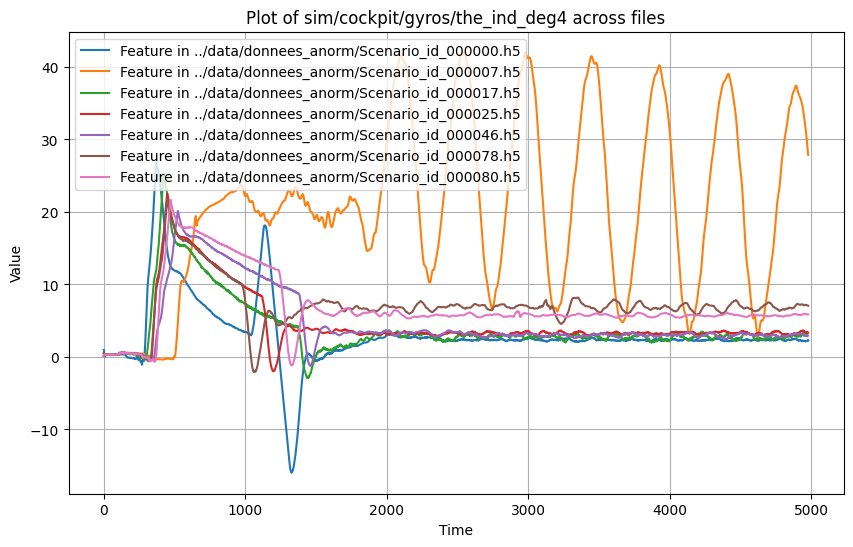

In [13]:
file_paths = ALL_FILES[93:100]
feature_name = "sim/cockpit/gyros/the_ind_deg4"
# feature_name = "sim/cockpit2/annunciators/hydraulic_pressure"
plot_feature_across_files(file_paths, feature_name)

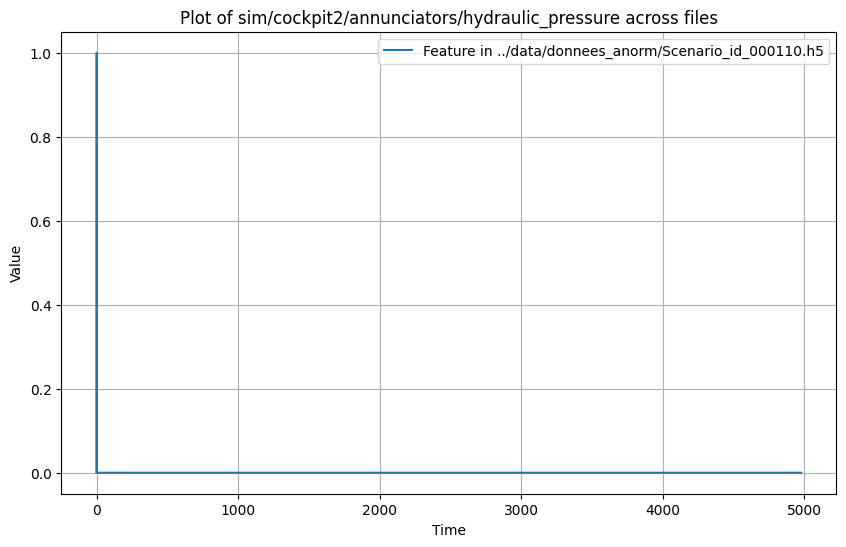

In [14]:
file_paths = ALL_FILES[101:102]
# feature_name = "sim/cockpit/gyros/the_ind_deg4"
feature_name = "sim/cockpit2/annunciators/hydraulic_pressure"
plot_feature_across_files(file_paths, feature_name)

In [75]:
# print(os.getcwd())
weird = pd.read_hdf('../data/donnees_anorm/Scenario_id_000110.h5')
not_weird = pd.read_hdf('../data/donnees_anorm/Scenario_id_000117.h5')

weird["sim/cockpit2/annunciators/hydraulic_pressure"].unique(),not_weird["sim/cockpit2/annunciators/hydraulic_pressure"].unique()
# print(pd.DataFrame([weird["sim/cockpit2/annunciators/hydraulic_pressure"],not_weird["sim/cockpit2/annunciators/hydraulic_pressure"]]))

                                              0     1     2     3     4     \
sim/cockpit2/annunciators/hydraulic_pressure   0.0   1.0   1.0   0.0   0.0   
sim/cockpit2/annunciators/hydraulic_pressure   0.0   0.0   0.0   0.0   0.0   

                                              5     6     7     8     9     \
sim/cockpit2/annunciators/hydraulic_pressure   0.0   0.0   0.0   0.0   0.0   
sim/cockpit2/annunciators/hydraulic_pressure   0.0   0.0   0.0   0.0   0.0   

                                              ...  4969  4970  4971  4972  \
sim/cockpit2/annunciators/hydraulic_pressure  ...   0.0   0.0   0.0   0.0   
sim/cockpit2/annunciators/hydraulic_pressure  ...   0.0   0.0   0.0   0.0   

                                              4973  4974  4975  4976  4977  \
sim/cockpit2/annunciators/hydraulic_pressure   0.0   0.0   0.0   0.0   0.0   
sim/cockpit2/annunciators/hydraulic_pressure   0.0   0.0   0.0   NaN   NaN   

                                              4978  
sim/cockpi

# Count Nan Values

In [123]:

# TODO: complete the function
Nan_df = pd.DataFrame(columns=const_features)

for file_ in ALL_FILES:
    data = pd.read_hdf(file_)
    unique_data = data.loc[:, ~data.columns.isin(const_features)]
    nan_count = unique_data.isna().sum()
    # count = len(nan_count.unique())
    # Assign the nan_count Series to a new row in Nan_df with the file name as the index
    Nan_df.loc[file_] = nan_count

Nan_df.describe().transpose()["count"].sum()


0.0

In [15]:
data = data.fillna(method='ffill')

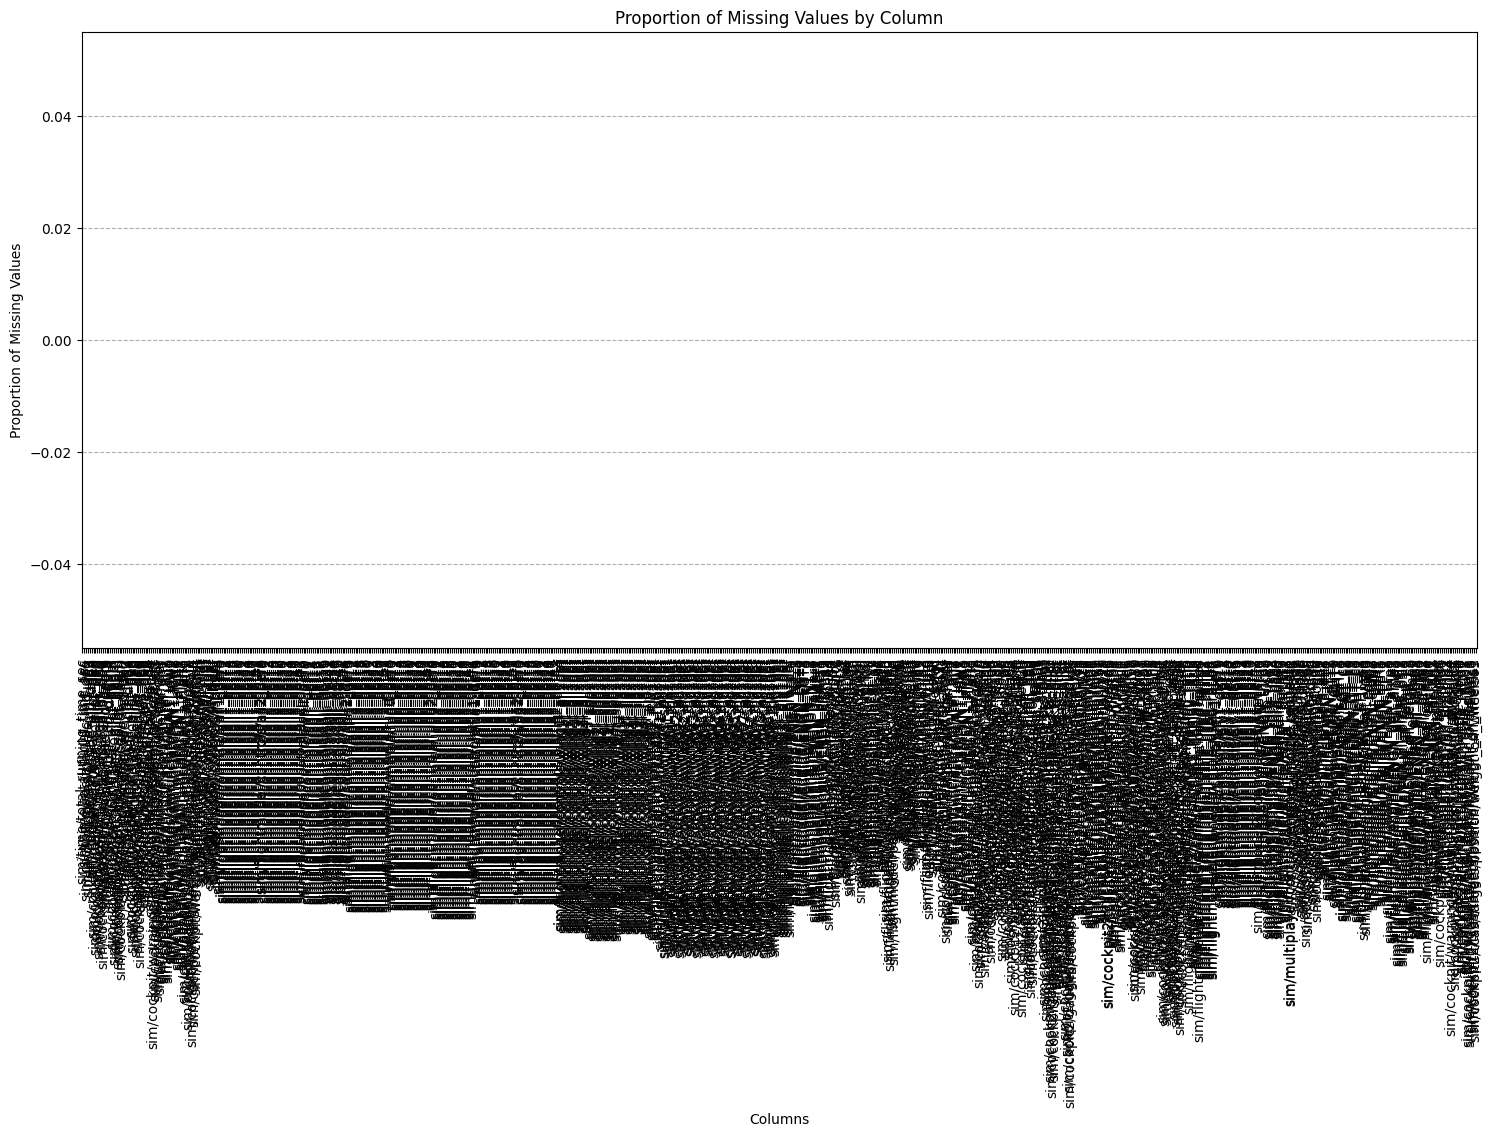

In [120]:
# weird = weird.loc[:, ~data.columns.isin(const_features)]
missing_ratio = weird.isnull().sum() / len(weird)

# Plotting
plt.figure(figsize=(18, 8))  # Set the figure size
missing_ratio.plot.bar(colormap='Paired')  # Create a bar plot with a specified colormap
plt.title('Proportion of Missing Values by Column')  # Add a title to the plot
plt.xlabel('Columns')  # Add an x-label
plt.ylabel('Proportion of Missing Values')  # Add a y-label
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--')  # Add horizontal grid lines for easier evaluation
plt.show()  # Display the plot

## Calculating covavriance matrix
we could then remove variables that are strongly correlated


In [16]:
import seaborn as sns

In [17]:
def remove_useless_features(data):
    unique_data = data.loc[:, ~data.columns.isin(const_features)]
    if 'sim/time/total_running_time_sec' in unique_data.columns:
        del unique_data['sim/time/total_running_time_sec']
    if 'sim/time/total_flight_time_sec' in unique_data.columns:
        del unique_data['sim/time/total_flight_time_sec']
    return unique_data

unique_data = remove_useless_features(data)

In [18]:
print(unique_data.columns)
print(len(unique_data.columns))

Index(['sim/cockpit/gyros/the_vac_ind_deg',
       'sim/cockpit/gyros/the_ele_ind_deg', 'sim/cockpit/gyros/the_ind_deg3',
       'sim/cockpit/gyros/the_ind_deg4',
       'sim/cockpit/gyros/the_ind_vac_pilot_deg',
       'sim/cockpit/gyros/the_ind_vac_copilot_deg',
       'sim/cockpit/gyros/the_ind_elec_pilot_deg',
       'sim/cockpit/gyros/the_ind_elec_copilot_deg',
       'sim/cockpit/gyros/the_ind_ahars_pilot_deg',
       'sim/cockpit/gyros/the_ind_ahars_copilot_deg',
       ...
       'sim/cockpit2/controls/gear_handle_down',
       'sim/cockpit2/engine/actuators/throttle_ratio0',
       'sim/cockpit2/engine/actuators/throttle_ratio1',
       'sim/cockpit2/engine/actuators/throttle_ratio2',
       'sim/cockpit2/engine/actuators/throttle_ratio3',
       'sim/cockpit2/hydraulics/indicators/hydraulic_pressure_1',
       'sim/cockpit2/hydraulics/indicators/hydraulic_pressure_2',
       'sim/cockpit2/tcas/targets/position/weight_on_wheels0',
       'sim/cockpit2/tcas/targets/position/wei

In [19]:
def remove_correlated_parameter(df):
    df_corr = df.corr(method='pearson')
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > 0.9999).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    print('Uncorrelate parameters:', len(un_corr_idx)) 
    # Find parameters to remove
    param_to_remove = set(df.columns) - set(un_corr_idx)
    print('Parameters to remove:', param_to_remove)
    #index_to_remove = [df.columns.index(p) for p in param_to_remove]
    # remove parameters from dataframe
    df_result = df.drop(columns=param_to_remove)
    return df_result

In [20]:
correlation_matrix = unique_data.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

KeyboardInterrupt: 

In [ ]:
correlation_matrix.head(10)

## Taking 1/n time steps to speed up computating

In [21]:
# Coarse Data (divide data by n)
def coerce_data(data, n):
    return data.iloc[::n, :]

coarse_data = coerce_data(unique_data,5)

In [22]:
print(coarse_data.shape)

(996, 749)


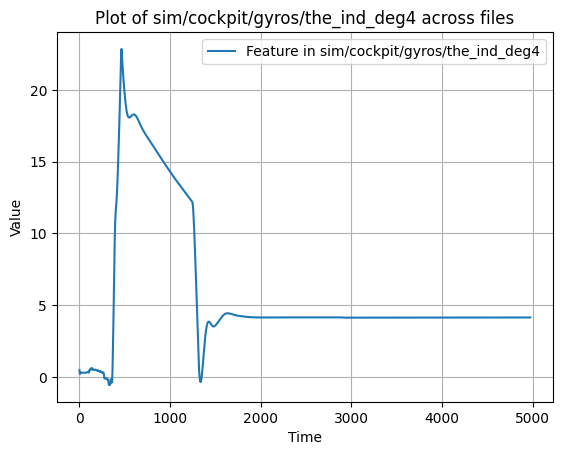

In [23]:
feature_name0 = "sim/cockpit/gyros/the_ind_deg4"
plt.plot(coarse_data.index, coarse_data[feature_name0], label=f"Feature in {feature_name0}")

# Finalizing the plot
plt.title(f"Plot of {feature_name0} across files")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## Normalize Series 

In [24]:
# TODO: scikit learn library (global)

def normalize_df(df,strategy="MinMax"):
    """
    This function normalizes the data using the MinMaxScaler or the StandardScaler
    """
    if strategy == "MinMax": 
        scaler = MinMaxScaler()
        # Fit the scaler to the data and transform it
        df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    else:
        scaler = StandardScaler()
        # Fit the scaler to the data and transform it
        df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        
    return df_normalized

In [25]:
db = normalize_df(coarse_data,"MinMax")
db = remove_correlated_parameter(db)
print(db.shape)
db.head(10)

Uncorrelate parameters: 203
Parameters to remove: {'sim/cockpit2/gauges/indicators/altitude_ft_pilot', 'sim/flightmodel/controls/elv1_def15', 'sim/cockpit2/tcas/targets/position/x1', 'sim/cockpit2/temperature/outside_air_temp_degc', 'sim/flightmodel/engine/ENGN_ITT_c1', 'sim/cockpit/engine/igniters_on1', 'sim/flightmodel/controls/wing3r_ail1def', 'sim/cockpit/engine/igniters_on2', 'sim/flightmodel/controls/flap2rat', 'sim/flightmodel/controls/ail2_def42', 'sim/flightmodel/controls/rudd_def26', 'sim/flightmodel/engine/ENGN_CHT1', 'sim/flightmodel/controls/splr_def16', 'sim/flightmodel/controls/mwing04_fla1def', 'sim/cockpit2/temperature/outside_air_temp_deg', 'sim/flightmodel/controls/ail1_def24', 'sim/flightmodel/controls/wing1l_spo1def', 'sim/cockpit2/annunciators/N1_high3', 'sim/flightmodel/controls/splr_def10', 'sim/flightmodel/engine/ENGN_power1', 'sim/flightmodel/controls/fla1_def22', 'sim/flightmodel/controls/ail1_def17', 'sim/cockpit2/temperature/outside_air_temp_degf', 'sim/fli

,sim/cockpit/gyros/the_vac_ind_deg,sim/cockpit/gyros/psi_vac_ind_degm,sim/cockpit/gyros/phi_vac_ind_deg,sim/cockpit/gyros/dg_drift_vac_deg,sim/cockpit/gyros/dg_drift_vac2_deg,sim/cockpit/gyros/dg_drift_ele_deg,sim/cockpit/gyros/dg_drift_ele2_deg,sim/cockpit/pressure/bleed_air_on,sim/cockpit/warnings/annunciators/autopilot_disconnect,sim/cockpit/warnings/annunciators/pitot_heat_off,...,sim/flightmodel/engine/apr_mode,sim/flightmodel2/gear/on_ground0,sim/flightmodel2/gear/on_ground1,sim/flightmodel2/gear/on_ground2,sim/flightmodel2/gear/on_ground3,sim/cockpit/warnings/annunciators/hydraulic_pressure,sim/cockpit2/annunciators/hydraulic_pressure,sim/cockpit2/hydraulics/indicators/hydraulic_pressure_1,sim/cockpit2/tcas/targets/position/weight_on_wheels1,sim/cockpit2/tcas/targets/position/weight_on_wheels63
0,0.043943,1.000000,0.976414,1.000000,0.212715,0.000000,0.000000,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.094876,1.0,0.0
1,0.032216,0.999917,0.960599,0.998761,0.211560,0.252644,0.085412,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,1.0,0.0
2,0.036465,0.999867,0.951530,0.997515,0.210367,0.404310,0.136339,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.046550,1.0,0.0
3,0.037593,0.999775,0.959992,0.996281,0.209234,0.495784,0.167576,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.096164,1.0,0.0
4,0.036155,0.999721,0.971610,0.995038,0.208060,0.550558,0.185894,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.148647,1.0,0.0
5,0.036270,0.999713,0.970314,0.993785,0.206830,0.583206,0.196322,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.204252,1.0,0.0
6,0.036581,0.999724,0.959984,0.992526,0.205575,0.602718,0.202354,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.263266,1.0,0.0
7,0.036377,0.999717,0.955943,0.991272,0.204344,0.614571,0.206241,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.326012,1.0,0.0
8,0.036282,0.999678,0.962563,0.990025,0.203149,0.621878,0.208956,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.390139,1.0,0.0
9,0.036267,0.999642,0.969216,0.988778,0.201954,0.626256,0.210556,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.454757,1.0,0.0


In [26]:
## Doing all of the above for all files
## This will take a while
features_count = 10  # We will take only 10 features
data_list = []
for file_path in ALL_FILES[:20]:
    d = pd.read_hdf(file_path)
    d = remove_useless_features(d)
    d = coerce_data(d, 5)
    d = d.reset_index()
    d = d.fillna(method='ffill')
    data_list.append(d)

all_data = pd.concat(data_list, axis=0)
all_data = remove_correlated_parameter(all_data)
all_data = normalize_df(all_data, "MinMax")
print(f"all_data shape: {all_data.shape}")


Uncorrelate parameters: 167
Parameters to remove: {'sim/cockpit2/gauges/indicators/altitude_ft_pilot', 'sim/flightmodel/controls/elv1_def15', 'sim/cockpit2/temperature/outside_air_temp_degc', 'sim/flightmodel/engine/ENGN_ITT_c1', 'sim/flightmodel/controls/wing3r_ail1def', 'sim/cockpit/engine/igniters_on1', 'sim/cockpit/engine/igniters_on2', 'sim/flightmodel/controls/ail2_def42', 'sim/flightmodel/controls/rudd_def26', 'sim/flightmodel/engine/ENGN_CHT1', 'sim/flightmodel/controls/splr_def16', 'sim/flightmodel/controls/mwing04_fla1def', 'sim/flightmodel/controls/ail1_def24', 'sim/flightmodel/controls/wing1l_spo1def', 'sim/cockpit2/annunciators/N1_high3', 'sim/flightmodel/controls/splr_def10', 'sim/flightmodel/engine/ENGN_power1', 'sim/flightmodel/controls/fla1_def22', 'sim/flightmodel/controls/ail1_def17', 'sim/cockpit2/temperature/outside_air_temp_degf', 'sim/flightmodel/controls/ail2_def19', 'sim/flightmodel/controls/splr_def15', 'sim/flightmodel2/controls/slat2_deploy_ratio', 'sim/cock

After scaling and everything, We shoumd convert the data into sequences. Each sequence will be a batch of consecutive time steps that we'll use as input for your autoencoder.

In [33]:
def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps + 1):
        X.append(data[i:(i + time_steps)])
    return np.array(X)

time_steps = all_data.shape[0] // 20
print(f"Number of time steps: {time_steps}")
X_train = create_sequences(all_data, time_steps)
print(f"X_train shape: {X_train.shape}")

Number of time steps: 995


MemoryError: Unable to allocate 23.4 GiB for an array with shape (18917, 995, 167) and data type float64

## Test Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from keras import regularizers

## Preparing Data for the model

In [27]:
"""data_concatenated = np.concatenate(data_list, axis=0)
data_concatenated.shape
sequence_length = 20  # We will use a sequence length of 20
# Reshape data for LSTM (assuming you've defined `sequence_length` and `features`)
samples = len(data_concatenated) - sequence_length + 1
train_data = np.array([data_concatenated[i:i+sequence_length] for i in range(samples)]).reshape(samples, sequence_length, 10)  # Assuming 10 features
train_data.shape

#(nbre_vol, time_steps, features)"""

(12422, 20, 10)

In [37]:
""""
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
"""
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model


model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 161)]         0         
                                                                 
 lstm (LSTM)                 (None, 10, 16)            11392     
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 4)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 4)             144       
                                                                 
 lstm_3 (LSTM)               (None, 10, 16)            1344      
                                                           

In [39]:
# fit the model to the data
nb_epochs = 10
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0928 - val_loss: 0.1056
Epoch 2/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0904 - val_loss: 0.1076
Epoch 3/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0887 - val_loss: 0.1056
Epoch 4/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0871 - val_loss: 0.1042
Epoch 5/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0861 - val_loss: 0.1040
Epoch 6/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0855 - val_loss: 0.1045
Epoch 7/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0853 - val_loss: 0.1046
Epoch 8/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0847 - val_loss: 0.1045
Epoch 9/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0847 - val_loss: 0.1049
Epoch 10/10
472/472 [==============================] - 3s 6ms/step - loss: 0.0841 - val_loss: 0.1048

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [41]:
test_d = pd.read_hdf(ALL_FILES[1])
test_d = remove_useless_features(test_d)
test_d = coerce_data(test_d, 2)
test_d = test_d.fillna(method='ffill')
test_d = normalize_df(test_d)
test_d = test_d.to_numpy()
prediction = model.predict(test_d)
reconstruction_errors = np.mean(np.power(data - prediction, 2), axis=1)
print(reconstruction_errors)

ValueError: in user code:

    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\playi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 10, 161), found shape=(None, 749)


In [ ]:
# Remove constant parameters
all_data = all_data.loc[:, (all_data != all_data.iloc[0]).any()] 
print('Unconstant parameters:', all_data.shape[1])
# Remove correlate parameters
# TODO : first, remove columns who are equals, to gain speed during correlation compute
df_corr = all_data.corr(method='pearson')
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > 0.9999).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
print('Uncorrelate parameters:', len(un_corr_idx)) 
# Find parameters to remove
param_to_remove = set(parameters) - set(un_corr_idx)
index_to_remove = [parameters.index(p) for p in param_to_remove]
# Format array 
inliers, outliers = np.array(inliers), np.array(outliers)
print('Shape before reducing parameters:', inliers.shape, outliers.shape) 